# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os 

# cschan dataset

In [3]:
csv_path = "../raw_data/wikiart/"

In [4]:
style_train = pd.read_csv(csv_path + "style_train.csv", header=None)
style_val = pd.read_csv(csv_path + "style_val.csv", header=None)
style = pd.concat([style_train, style_val], ignore_index=True)
style.columns = ["path", "style_id"]

genre_train = pd.read_csv(csv_path + "genre_train.csv", header=None)
genre_val = pd.read_csv(csv_path + "genre_val.csv", header=None)
genre = pd.concat([genre_train, genre_val], ignore_index=True)
genre.columns = ["path", "genre_id"]

artist_train = pd.read_csv(csv_path + "artist_train.csv", header=None)
artist_val = pd.read_csv(csv_path + "artist_val.csv", header=None)
artist = pd.concat([artist_train, artist_val], ignore_index=True)
artist.columns = ["path", "artist_id"]

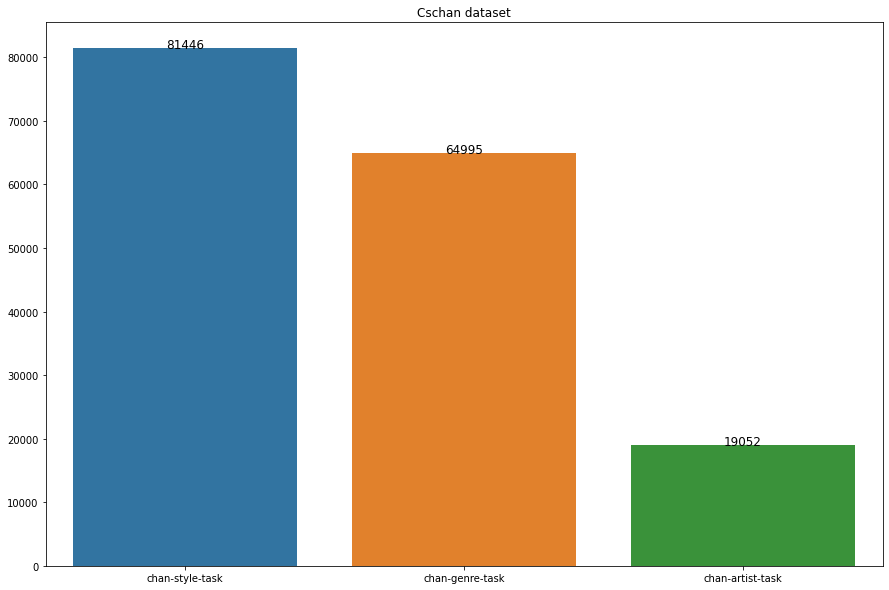

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.barplot(x=["chan-style-task", "chan-genre-task", "chan-artist-task"], y=[style.shape[0], genre.shape[0], artist.shape[0]], ax=ax)

ax.set_title("Cschan dataset")
for i, j in enumerate([style.shape[0], genre.shape[0], artist.shape[0]]):
    ax.text(i, j, j, color='black', ha="center", fontsize=12)

In [6]:
genre["style-from-path"] = genre["path"].apply(lambda x: x.split('/')[0])
genre["artist-from-path"] = genre["path"].apply(lambda x: x.split('/')[1].split('_')[0])
genre["title-from-path"] = genre["path"].apply(lambda x: x.split('/')[1].split('_')[1])

artist["style-from-path"] = artist["path"].apply(lambda x: x.split('/')[0])
artist["artist-from-path"] = artist["path"].apply(lambda x: x.split('/')[1].split('_')[0])
artist["title-from-path"] = artist["path"].apply(lambda x: x.split('/')[1].split('_')[1])

style["style-from-path"] = style["path"].apply(lambda x: x.split('/')[0])
style["artist-from-path"] = style["path"].apply(lambda x: x.split('/')[1].split('_')[0])
style["title-from-path"] = style["path"].apply(lambda x: x.split('/')[1].split('_')[1])

In [7]:
artist

,path,artist_id,style-from-path,artist-from-path,title-from-path
0,Realism/vincent-van-gogh_pine-trees-in-the-fen...,22,Realism,vincent-van-gogh,pine-trees-in-the-fen-1884.jpg
1,Baroque/rembrandt_the-angel-appearing-to-the-s...,20,Baroque,rembrandt,the-angel-appearing-to-the-shepherds-1634.jpg
2,Post_Impressionism/paul-cezanne_portrait-of-th...,16,Post_Impressionism,paul-cezanne,portrait-of-the-artist-s-son.jpg
3,Impressionism/pierre-auguste-renoir_young-girl...,17,Impressionism,pierre-auguste-renoir,young-girl-seated-in-a-meadow-1916.jpg
4,Romanticism/ivan-aivazovsky_morning-1851.jpg,9,Romanticism,ivan-aivazovsky,morning-1851.jpg
...,...,...,...,...,...
19047,Cubism/pablo-picasso_two-naked-figures.jpg,15,Cubism,pablo-picasso,two-naked-figures.jpg
19048,Symbolism/pablo-picasso_the-tragedy-1903.jpg,15,Symbolism,pablo-picasso,the-tragedy-1903.jpg
19049,Expressionism/pablo-picasso_drunk-woman-is-tir...,15,Expressionism,pablo-picasso,drunk-woman-is-tired-1902.jpg
19050,Expressionism/pablo-picasso_untitled-1958-1.jpg,15,Expressionism,pablo-picasso,untitled-1958-1.jpg


In [8]:
genre

,path,genre_id,style-from-path,artist-from-path,title-from-path
0,Northern_Renaissance/hieronymus-bosch_st-jacqu...,7,Northern_Renaissance,hieronymus-bosch,st-jacques-and-the-magician-hermogenes.jpg
1,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4,Post_Impressionism,vincent-van-gogh,ears-of-wheat-1890(1).jpg
2,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3,Symbolism,theodor-severin-kittelsen,kvitebj-rn-kong-valemon-1912-2.jpg
3,Expressionism/martiros-saryan_mother-of-the-ar...,6,Expressionism,martiros-saryan,mother-of-the-artist-1904.jpg
4,Early_Renaissance/leonardo-da-vinci_study-for-...,8,Early_Renaissance,leonardo-da-vinci,study-for-the-madonna-with-the-fruit-bowl.jpg
...,...,...,...,...,...
64990,Minimalism/rodolfo-arico_untitled-1965-1.jpg,0,Minimalism,rodolfo-arico,untitled-1965-1.jpg
64991,Abstract_Expressionism/perle-fine_sunblinded-1...,0,Abstract_Expressionism,perle-fine,sunblinded-1946.jpg
64992,Abstract_Expressionism/john-hoyland_trickster-...,0,Abstract_Expressionism,john-hoyland,trickster-1979.jpg
64993,Abstract_Expressionism/richard-pousette-dart_b...,0,Abstract_Expressionism,richard-pousette-dart,by-the-sea.jpg


In [7]:
genre = [i for i in os.listdir(csv_path + 'wikiart') if i != '.DS_Store']


['Early_Renaissance',
 'Analytical_Cubism',
 'Mannerism_Late_Renaissance',
 'Expressionism',
 'Contemporary_Realism',
 'Fauvism',
 'Northern_Renaissance',
 'Rococo',
 'Ukiyo_e',
 'Pop_Art',
 'High_Renaissance',
 'Minimalism',
 'Art_Nouveau_Modern',
 'Action_painting',
 'Color_Field_Painting',
 'Symbolism',
 'Realism',
 'Romanticism',
 'Cubism',
 'Impressionism',
 'New_Realism',
 'Baroque',
 'Post_Impressionism',
 'Abstract_Expressionism',
 'Pointillism',
 'Synthetic_Cubism',
 'Naive_Art_Primitivism']